# Imports

In [1]:
# set up
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import string
import cvxopt # <- installation via conda recommended
from collections import defaultdict
from sklearn import metrics
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import scipy.optimize as sopt
import scipy.stats as sstats

# Preparing data (IMDb movies' reviews)

## Macro for windows / mac users

In [2]:
#system = 'Mac'
system = 'Win'

In [3]:
train_pos_path = 'data_sets/aclImdb/train/pos/*'
train_neg_path = 'data_sets/aclImdb/train/neg/*'

train_pos = glob.glob(train_pos_path)
train_neg = glob.glob(train_neg_path)


test_pos_path = 'data_sets/aclImdb/test/pos/*'
test_neg_path = 'data_sets/aclImdb/test/neg/*'

test_pos = glob.glob(test_pos_path)
test_neg = glob.glob(test_neg_path)

In [4]:
train_df = []
test_df = []

In [5]:
def read_data(path, message):
    res = []
    for p in tqdm(path, desc=message, position=0):
        with open(p, encoding="utf8") as f:
            text = f.read()

    #         For win users
            if system == 'Win':
                beg, end = p.find('\\'), p.find('.')

    #         For mac users
            if system == 'Mac':
                beg = re.search(r"\d",p).start()-1
                end = p.find('.')

            idx, rating = p[beg+1:-4].split('_')
            res.append([text, rating])
            
    return res

In [6]:
train_df += read_data(path=train_pos, message='Getting positive train data')
train_df += read_data(path=train_neg, message='Getting negative train data')

test_df += read_data(path=test_pos, message='Getting positive test data')
test_df += read_data(path=test_neg, message='Getting negative test data')

Getting negative test data: 100%|███████████████████████████████████████████████| 12500/12500 [00:50<00:00, 248.30it/s]


In [7]:
train_df = pd.DataFrame(train_df, columns=['text', 'rating'])
test_df = pd.DataFrame(test_df, columns=['text', 'rating'])

In [8]:
print('Records: ', train_df.size)
train_df.head()

Records:  50000


,text,rating
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,Homelessness (or Houselessness as George Carli...,8
2,Brilliant over-acting by Lesley Ann Warren. Be...,10
3,This is easily the most underrated film inn th...,7
4,This is not the typical Mel Brooks film. It wa...,8


In [9]:
for i in range(1, 11):
    print(f'Number of reviews with rating {i}: {train_df[train_df.rating == str(i)].shape[0]}')

Number of reviews with rating 1: 5100
Number of reviews with rating 2: 2284
Number of reviews with rating 3: 2420
Number of reviews with rating 4: 2696
Number of reviews with rating 5: 0
Number of reviews with rating 6: 0
Number of reviews with rating 7: 2496
Number of reviews with rating 8: 3009
Number of reviews with rating 9: 2263
Number of reviews with rating 10: 4732


## Clean and Preprocess

In [10]:
def regex(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

## Remove punctuation

In [11]:
%%time
# Remove punctuaction and lower all texts
train_df.text = train_df.text.apply(lambda row: regex(row))
test_df.text = test_df.text.apply(lambda row: regex(row))

Wall time: 2.71 s


In [12]:
train_df.head()

,text,rating
0,bromwell high is a cartoon comedy it ran at th...,9
1,homelessness or houselessness as george carlin...,8
2,brilliant overacting by lesley ann warren best...,10
3,this is easily the most underrated film inn th...,7
4,this is not the typical mel brooks film it was...,8


In [13]:
# consider only rating 1 and 10
bayes_df_train = train_df[(train_df.rating == '1') | (train_df.rating == '10')]
bayes_df_test = test_df[(test_df.rating == '1') | (test_df.rating == '10')]

## Stemming

In [14]:
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Mateusz
[nltk_data]     Markiewicz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def stem_(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [16]:
%%time
stemmed_train_df = bayes_df_train.copy()
stemmed_test_df = bayes_df_test.copy()
stemmed_train_df.text = stemmed_train_df.text.apply(lambda row: stem_(row))
stemmed_test_df.text = stemmed_test_df.text.apply(lambda row: stem_(row))

Wall time: 1min 3s


## Remove stop words

In [17]:
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [18]:
%%time
swr_train_df = bayes_df_train.copy()
swr_test_df = bayes_df_test.copy()
swr_train_df.text = swr_train_df.text.apply(lambda row: remove_stop_words(row))
swr_test_df.text = swr_test_df.text.apply(lambda row: remove_stop_words(row))

Wall time: 951 ms


In [19]:
def stem_and_remove_stop_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

In [20]:
%%time
stemmed_swr_train_df = bayes_df_train.copy()
stemmed_swr_test_df = bayes_df_test.copy()
stemmed_swr_train_df.text = stemmed_swr_train_df.text.apply(lambda row: stem_and_remove_stop_words(row))
stemmed_swr_test_df.text = stemmed_swr_test_df.text.apply(lambda row: stem_and_remove_stop_words(row))

Wall time: 40.6 s


## Score visualization

In [21]:
def print_score(preds,Y,name):
    print(name)
    acc = np.mean(preds == Y)
    print(f"Acc: {acc}")
    M = metrics.confusion_matrix(preds,Y)
    N = np.sum(M)
    print('\nConfusion matrix:')
    print(M)
    print(f'\nTrue negative (rating = 1): {M[0][0]}')
    print(f'True positive (rating = 10): {M[1][1]}')
    print(f'False negative: {M[0][1]}')
    print(f'False positive: {M[1][0]}')
    return M,N,acc

# CountVectorizer class

In [22]:
class MyCountVectorizer:
    def __init__(self, min_df=-1, max_df=1e18, binary=False):
        self.min_df = min_df
        self.max_df = max_df
        self.binary = binary
    
    def fit(self, df):
        words_cnt = defaultdict(int)
        col = df.columns[0]
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            for word in text.split():
                words_cnt[word] += 1
                
        all_words = []
        for word, cnt in words_cnt.items():
            if self.min_df <= cnt <= self.max_df:
                all_words.append(word)
                
        self.all_words_ids = {w:i for i,w in enumerate(all_words)}
        self.width = len(all_words)
        
    
    def transform(self, df):
        col = df.columns[0]
        count_matrix = np.zeros([len(df), self.width], \
                                dtype=np.int32)
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            words_cnt = defaultdict(int)
            
            for word in text.split():
                words_cnt[word] += 1
            
            for word, cnt in words_cnt.items():
                if word in self.all_words_ids:
                    pos = self.all_words_ids[word]
                    if self.binary:
                        count_matrix[i][pos] = 1
                    else:
                        count_matrix[i][pos] = cnt
                    
        return count_matrix

# Naive Bayes approach

## Naive Bayes class

In [27]:
class Naive_Bayes:
    def __init__(self,alpha=0,fit_prior=True,class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior_array = class_prior
        if class_prior:
            self.fit_prior = False
    
    
    def fit(self,X,y):
        self.classes,prior = np.unique(y,return_counts=True)
        self.N = len(y)
        
        # Setting class prior
        if self.fit_prior:
            self.class_prior = {class_ : np.log(prior[i]/self.N + 1e-100)
                                for i,class_ in enumerate(self.classes)}
        elif self.class_prior_array:
            self.class_prior = {class_ : np.log(self.class_prior_array[i] + 1e-100) 
                                for i,class_ in enumerate(self.classes)}
        else:
            self.class_prior = {class_ : np.log(1/len(self.classes) + 1e-100) 
                                for class_ in self.classes}
            
        # Creating words dictionaries
        self.class_words_counts = {class_ : defaultdict(lambda: 0) 
                                   for class_ in self.classes}
        for i,text in enumerate(X):
            target = y[i]
            for word in text.split():
                self.class_words_counts[target][word] += 1
        
        # Creating probabilities dictionaries
        self.class_words_probs = {class_ : defaultdict(lambda: np.log(self.alpha + 1e-100)) 
                                  for class_ in self.classes}
        for class_,dict_ in self.class_words_counts.items():
            for word,count in dict_.items():
                self.class_words_probs[class_][word] = np.log(count + 1e-100)
    
        self.class_words_amount = {class_ : np.log(sum(self.class_words_counts[class_].values())) 
                                   for class_ in self.classes}
    

    def get_class_log_probabilities(self,text):
        probs = {class_ : 0 for class_ in self.classes}
        for class_ in self.classes:
            for word in text.split():
                probs[class_] += self.class_words_probs[class_][word]
                probs[class_] -= self.class_words_amount[class_]
            probs[class_] += self.class_prior[class_]
        return probs
    
    
    def predict(self,X,return_probabilities = False):
        preds = []
        preds_probs = []
        for text in X:
            prob = self.get_class_log_probabilities(text)
            #prob = {class_ : np.exp(pbb) for class_,pbb in prob.items()}
            preds_probs.append(prob)
            pred = max(prob,key = prob.get)
            preds.append(pred)
        
        if return_probabilities:
            return preds,preds_probs
        return preds


## Train and test accuracy

In [43]:
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])

In [44]:
NBc_res = []

In [45]:
alpha = 1.5
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [46]:
NB.fit(X_train,y_train)

In [47]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [48]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBc_res.append(['Org train data\na=1.5','Acc',acc])
NBc_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

TRAIN, alpha : 1.5
Acc: 0.9363303498779495

Confusion matrix:
[[4904  430]
 [ 196 4302]]

True negative (rating = 1): 4904
True positive (rating = 10): 4302
False negative: 430
False positive: 196


In [49]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [50]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBc_res.append(['Org test data\na=1.5','Acc',acc])
NBc_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5
Acc: 0.8893324019558926

Confusion matrix:
[[4651  738]
 [ 371 4261]]

True negative (rating = 1): 4651
True positive (rating = 10): 4261
False negative: 738
False positive: 371


Now we can try use alpha = 0

In [51]:
alpha = 0.0
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [52]:
NB.fit(X_train,y_train)

In [53]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [54]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")

TRAIN, alpha : 0.0
Acc: 0.9899308380797396

Confusion matrix:
[[5092   91]
 [   8 4641]]

True negative (rating = 1): 5092
True positive (rating = 10): 4641
False negative: 91
False positive: 8


In [55]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [56]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")

TEST, alpha : 0.0
Acc: 0.7240794331903003

Confusion matrix:
[[3932 1675]
 [1090 3324]]

True negative (rating = 1): 3932
True positive (rating = 10): 3324
False negative: 1675
False positive: 1090


Setting alpha to 0 improve our train accuracy, but decrease train accuracy, so it`s overfitting. 
We can try to find best alpha for our data.

## Testing different alphas

In [57]:
for alpha in [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,3.0,4.0,5.0,10.0]:
    NB = Naive_Bayes(fit_prior = False,alpha=alpha)
    NB.fit(X_train,y_train)
    predictions,ppb = NB.predict(X_test,return_probabilities=True)
    acc = np.mean(predictions == y_test)
    print(f'Alpha : {alpha}, test acc: {acc}')

Alpha : 0.0, test acc: 0.7240794331903003
Alpha : 0.25, test acc: 0.8820476998303562
Alpha : 0.5, test acc: 0.8868376409539966
Alpha : 0.75, test acc: 0.8882347071150584
Alpha : 1.0, test acc: 0.8884342879952101
Alpha : 1.25, test acc: 0.8881349166749826
Alpha : 1.5, test acc: 0.8893324019558926
Alpha : 1.75, test acc: 0.8884342879952101
Alpha : 2.0, test acc: 0.8882347071150584
Alpha : 3.0, test acc: 0.8872368027142999
Alpha : 4.0, test acc: 0.8862388983135415
Alpha : 5.0, test acc: 0.8830456042311147
Alpha : 10.0, test acc: 0.8759604829857299


## Stemming and stop words removing

In [58]:
alpha = 1.5

In [59]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating']))
predictions = NB.predict(np.array(stemmed_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed")
NBc_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8827462329108872

Confusion matrix:
[[4623  776]
 [ 399 4223]]

True negative (rating = 1): 4623
True positive (rating = 10): 4223
False negative: 776
False positive: 399


In [60]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(swr_train_df['text']),np.array(swr_test_df['rating']))
predictions = NB.predict(np.array(swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stop words removed")
NBc_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stop words removed
Acc: 0.8995110268436284

Confusion matrix:
[[4656  641]
 [ 366 4358]]

True negative (rating = 1): 4656
True positive (rating = 10): 4358
False negative: 641
False positive: 366


In [61]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating']))
predictions = NB.predict(np.array(stemmed_swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed and stop words removed")
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed and stop words removed
Acc: 0.8914280011974853

Confusion matrix:
[[4627  693]
 [ 395 4306]]

True negative (rating = 1): 4627
True positive (rating = 10): 4306
False negative: 693
False positive: 395


In [62]:
NBc_res_df = pd.DataFrame(NBc_res,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Our Naive Bayes class')

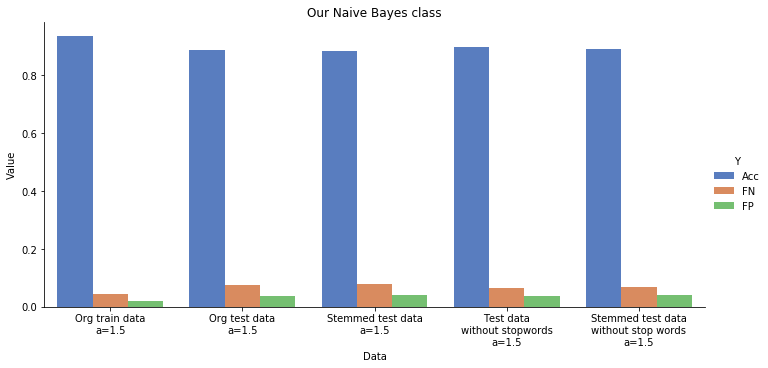

In [63]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class")

## Sklearn Naive Bayes

In [64]:
NBb_res = []

In [65]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [66]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_train_cv)
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBb_res.append(['Org train data\na=1.5','Acc',acc])
NBb_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

TRAIN, alpha : 1.5
Acc: 0.9509764035801465

Confusion matrix:
[[5009  391]
 [  91 4341]]

True negative (rating = 1): 5009
True positive (rating = 10): 4341
False negative: 391
False positive: 91


In [67]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBb_res.append(['Org test data\na=1.5','Acc',acc])
NBb_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5
Acc: 0.884742041712404

Confusion matrix:
[[4738  871]
 [ 284 4128]]

True negative (rating = 1): 4738
True positive (rating = 10): 4128
False negative: 871
False positive: 284


In [68]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating'])
X_test,y_test = np.array(stemmed_test_df['text']),np.array(stemmed_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [69]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8805508432292186

Confusion matrix:
[[4710  885]
 [ 312 4114]]

True negative (rating = 1): 4710
True positive (rating = 10): 4114
False negative: 885
False positive: 312


In [70]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(swr_train_df['text']),np.array(swr_train_df['rating'])
X_test,y_test = np.array(swr_test_df['text']),np.array(swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [71]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8932242291188505

Confusion matrix:
[[4752  800]
 [ 270 4199]]

True negative (rating = 1): 4752
True positive (rating = 10): 4199
False negative: 800
False positive: 270


In [72]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating'])
X_test,y_test = np.array(stemmed_swr_test_df['text']),np.array(stemmed_swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [73]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

TEST, alpha : 1.5, stemmed
Acc: 0.8907294681169544

Confusion matrix:
[[4713  786]
 [ 309 4213]]

True negative (rating = 1): 4713
True positive (rating = 10): 4213
False negative: 786
False positive: 309


In [74]:
NBb_res_df = pd.DataFrame(NBb_res,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Sklearn MultinomialNaiveBayes')

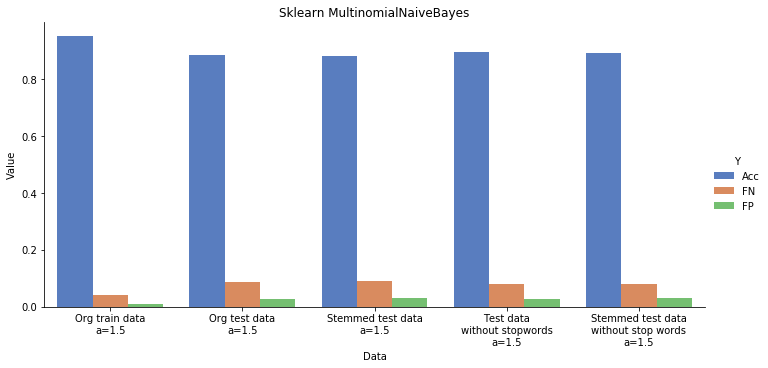

In [75]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBb_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Sklearn MultinomialNaiveBayes")

## Compare our NB with sklearn`s

In [76]:
NBc_res_df_copyed = NBc_res_df.copy()
A_df = NBc_res_df[NBc_res_df.Y == 'Acc']
A_df.Y = ['Our'] * 5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [77]:
NBb_res_df_copyed = NBb_res_df.copy()
B_df = NBb_res_df[NBb_res_df.Y == 'Acc']
B_df.Y = ['Sklearn'] * 5

In [78]:
compare_df = pd.concat([A_df,B_df])

Text(0.5, 1, 'Our Naive Bayes class vs Sklearn MultinomialNaiveBayes')

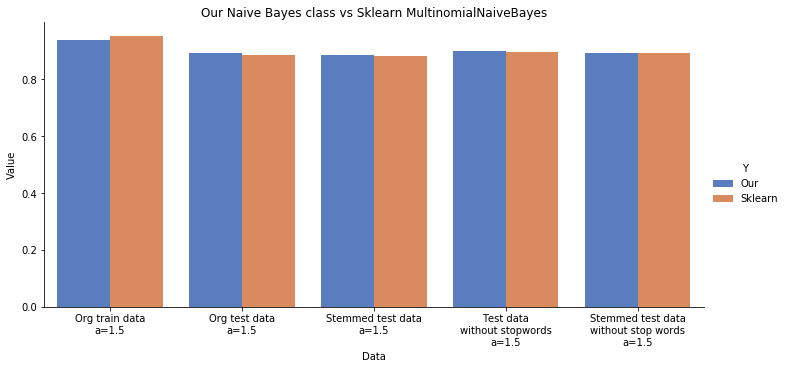

In [79]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.ylim(0.9,1.0)
plt.title("Our Naive Bayes class vs Sklearn MultinomialNaiveBayes")

# Logistic Regression

## Logistic Regression class

In [26]:
class Logistic_Regression:
    def __init__(self, max_iter=500, solver_calls=5,lambda_ = 0.1,Theta=None, solver=sopt.fmin_l_bfgs_b, debug=False):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
        self.debug = debug
        self.lambda_ = lambda_
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))    
    
    def __logreg_loss(self, Theta, X, Y):
        Theta = Theta.astype(np.float64)
        X = X.astype(np.float64)
        Y = Y.astype(np.float64)
        
        if self.debug:
            print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        if self.debug:
            print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        Y_ = Y[:,np.newaxis]
        nll = -np.sum((Y_*np.log2(SZ+1e-50) + (1-Y_)*np.log2(1-SZ+1e-50)))
#         nll = -np.mean([
#                         y * np.log2(SZ + 1e-10) \
#                         + (1-y) * np.log2(1 - SZ + 1e-10) \
#                         for y in Y
#                         ])
        nll += (self.lambda_/2) * np.sum(Theta**2)
        if self.debug:
            print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T ) / len(Y)
        grad = grad.reshape(Theta.shape) + self.lambda_ * Theta
        if self.debug:
            print(f" grad done... done ")
        return nll, grad
    
    def fit(self,X,y):
        Theta = self.Theta
        if Theta is None:
            Theta = np.ones(X.shape[1]+1)
        
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
      
        for i in tqdm(range(self.solver_calls), desc='Calculating Theta', position=0):
            Theta = self.solver(lambda th: self.__logreg_loss(th, X_with_ones, y), 
                                Theta, maxiter=self.max_iter)[0]
        self.Theta = Theta
    
#     def __logreg_classify(self, X):
#         return (self.Theta.T.dot(X) >= 0)

#     def predict(self, Xs):
#         return [self.__logreg_classify(x) for x in Xs]
    
    def predict(self,X):
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
        preds = (np.dot(self.Theta,X_with_ones.T) >= 0) * 1
        return preds
        

## Train and test accuracy

In [27]:
LGc_res = []

y_train = np.array(list(map(int, bayes_df_train['rating']))) // 10
y_test = np.array(list(map(int, bayes_df_test['rating']))) // 10

In [29]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(bayes_df_train)

X_train = cv.transform(bayes_df_train) 
X_test = cv.transform(bayes_df_test)

Wall time: 7.68 s


In [25]:
#Theta_beg = pd.read_csv('Theta_opt_rawtext.csv')['Theta']

In [30]:
LR = Logistic_Regression(max_iter=10, solver_calls=2,lambda_=0.1, Theta=None, debug=False)

SyntaxError: invalid syntax (<ipython-input-30-82b9d8268da4>, line 1)

In [94]:
%%time
LR.fit(X_train, y_train)

Calculating Theta:   0%|                                                                         | 0/1 [00:00<?, ?it/s]C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
Calculating Theta: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.12s/it]


Wall time: 17.1 s


In [94]:
#pd.DataFrame(LR.Theta, columns=['Theta']).to_csv('Theta_opt_rawtext.csv')

In [95]:
predictions = LR.predict(X_train)

In [96]:
M, N, acc = print_score(predictions, y_train, 'TRAIN')
LGc_res.append(['Org train data\n','Acc',acc])
LGc_res.append(['Org train data\n','FN',M[0][1]/N])
LGc_res.append(['Org train data\n','FP',M[1][0]/N])

TRAIN
Acc: 0.5117982099267697

Confusion matrix:
[[4706 4406]
 [ 394  326]]

True negative (rating = 1): 4706
True positive (rating = 10): 326
False negative: 4406
False positive: 394


In [97]:
predictions = LR.predict(X_test)

In [98]:
M, N, acc = print_score(predictions, y_test, 'TEST')
LGc_res.append(['Org test data\n','Acc',acc])
LGc_res.append(['Org test data\n','FN',M[0][1]/N])
LGc_res.append(['Org test data\n','FP',M[1][0]/N])

TEST
Acc: 0.4988524099391278

Confusion matrix:
[[4686 4686]
 [ 336  313]]

True negative (rating = 1): 4686
True positive (rating = 10): 313
False negative: 4686
False positive: 336


## Stemming and stop words removal

In [241]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(stemmed_swr_train_df)

X_train = cv.transform(stemmed_swr_train_df) 
X_test = cv.transform(stemmed_swr_test_df)

Wall time: 6.71 s


In [99]:
Theta_beg = pd.read_csv('Theta_opt_stem_stop.csv')['Theta']

In [251]:
LR = Logistic_Regression(max_iter=10, solver_calls=2,lambda_=0.1, Theta=None, debug=False)

In [252]:
%%time
LR.fit(X_train, y_train)

Calculating Theta: 100%|█████████████████████████████████████████████████████████████████| 2/2 [01:52<00:00, 56.05s/it]


Wall time: 1min 52s


In [104]:
pd.DataFrame(LR.Theta, columns=['Theta']).to_csv('Theta_opt_stem_stop.csv')

In [253]:
predictions = LR.predict(X_train)

In [254]:
M, N, acc = print_score(predictions, y_train, 'STEMMED TRAIN WITHOUT STOP WORDS')
LGc_res.append(['Stemmed train data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TRAIN WITHOUT STOP WORDS
Acc: 0.911513425549227

Confusion matrix:
[[4663  433]
 [ 437 4299]]

True negative (rating = 1): 4663
True positive (rating = 10): 4299
False negative: 433
False positive: 437


In [255]:
predictions = LR.predict(X_test)

In [256]:
M, N, acc = print_score(predictions, y_test, 'STEMMED TEST WITHOUT STOP WORDS')
LGc_res.append(['Stemmed test data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TEST WITHOUT STOP WORDS
Acc: 0.9012074643249177

Confusion matrix:
[[4540  508]
 [ 482 4491]]

True negative (rating = 1): 4540
True positive (rating = 10): 4491
False negative: 508
False positive: 482


In [111]:
LGc_res_df = pd.DataFrame(LGc_res,columns=['Data','Y','Value'])

Text(0.5, 1, 'Our Linear Regression class')

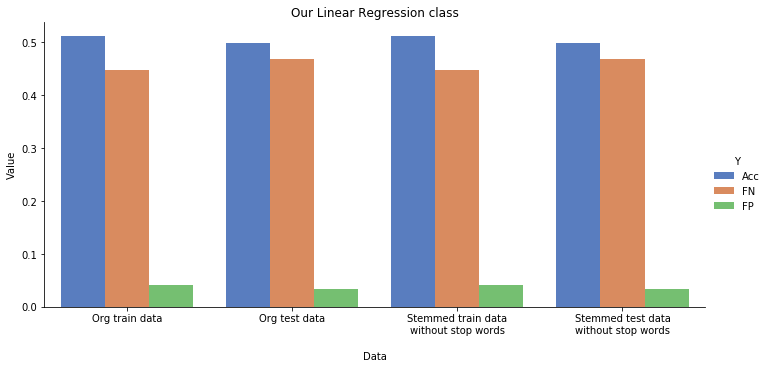

In [112]:
sns.catplot(x="Data", y="Value", hue="Y", data=LGc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Linear Regression class")

## Sklearn Linear Regression

In [132]:
%%time
cv = CountVectorizer(min_df=5)
cv.fit(stemmed_swr_train_df.text)
cv2 = CountVectorizer(min_df=5)
cv2.fit(bayes_df_train.text)

X_train_og = cv2.transform(bayes_df_train.text)
X_test_og = cv2.transform(bayes_df_test.text)

X_train_stem_swr = cv.transform(stemmed_swr_train_df.text)
X_test_stem_swr = cv.transform(stemmed_swr_test_df.text)

y_train = np.array(list(map(int, bayes_df_train['rating']))) // 10
y_test = np.array(list(map(int, bayes_df_test['rating']))) // 10

LG2_res = []

Wall time: 6.35 s


In [133]:
%%time
for c in [0.01, 0.05, 0.25, 0.5, 1, 5]:    
    lr = LogisticRegression(C=c, max_iter=500, solver='lbfgs') 
    lr.fit(X_train_og, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test_og))))

Accuracy for C=0.01: 0.9154774972557629
Accuracy for C=0.05: 0.9246582177427403
Accuracy for C=0.25: 0.9228619898213751
Accuracy for C=0.5: 0.92106576190001
Accuracy for C=1: 0.9190699530984932
Accuracy for C=5: 0.9140804310947012
Wall time: 10.9 s


In [134]:
best_C = 0.05
best_lr = LogisticRegression(C=best_C, max_iter=500, solver='lbfgs') 
best_lr.fit(X_train_og, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
M, N, acc = print_score(best_lr.predict(X_train_og), y_train, 'TRAIN')
LG2_res.append(['Org train data\n','Acc',acc])
LG2_res.append(['Org train data\n','FN',M[0][1]/N])
LG2_res.append(['Org train data\n','FP',M[1][0]/N])

TRAIN
Acc: 0.9790480065093572

Confusion matrix:
[[4993   99]
 [ 107 4633]]

True negative (rating = 1): 4993
True positive (rating = 10): 4633
False negative: 99
False positive: 107


In [136]:
M, N, acc = print_score(best_lr.predict(X_test_og), y_test, 'TEST')
LG2_res.append(['Org test data\n','Acc',acc])
LG2_res.append(['Org test data\n','FN',M[0][1]/N])
LG2_res.append(['Org test data\n','FP',M[1][0]/N])

TEST
Acc: 0.9246582177427403

Confusion matrix:
[[4618  351]
 [ 404 4648]]

True negative (rating = 1): 4618
True positive (rating = 10): 4648
False negative: 351
False positive: 404


In [137]:
# stemmed data without stop words
best_C = 0.05
lrs = LogisticRegression(C=best_C, max_iter=500, solver='lbfgs') 
lrs.fit(X_train_stem_swr, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [138]:
M, N, acc = print_score(lrs.predict(X_train_stem_swr), y_train, 'STEMMED TRAIN WITHOUT STOP WORDS')
LG2_res.append(['Stemmed train data\nwithout stop words\n','Acc',acc])
LG2_res.append(['Stemmed train data\nwithout stop words\n','FN',M[0][1]/N])
LG2_res.append(['Stemmed train data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TRAIN WITHOUT STOP WORDS
Acc: 0.9736574450772986

Confusion matrix:
[[4952  111]
 [ 148 4621]]

True negative (rating = 1): 4952
True positive (rating = 10): 4621
False negative: 111
False positive: 148


In [139]:
M, N, acc = print_score(lrs.predict(X_test_stem_swr), y_test, 'STEMMED TEST WITHOUT STOP WORDS')
LG2_res.append(['Stemmed test data\nwithout stop words\n','Acc',acc])
LG2_res.append(['Stemmed test data\nwithout stop words\n','FN',M[0][1]/N])
LG2_res.append(['Stemmed test data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TEST WITHOUT STOP WORDS
Acc: 0.9215647141003892

Confusion matrix:
[[4584  348]
 [ 438 4651]]

True negative (rating = 1): 4584
True positive (rating = 10): 4651
False negative: 348
False positive: 438


In [140]:
LG2_res_df  = pd.DataFrame(LG2_res, columns = ['Data','Y','Value'])

Text(0.5, 1, 'Sklearn Linear Regression')

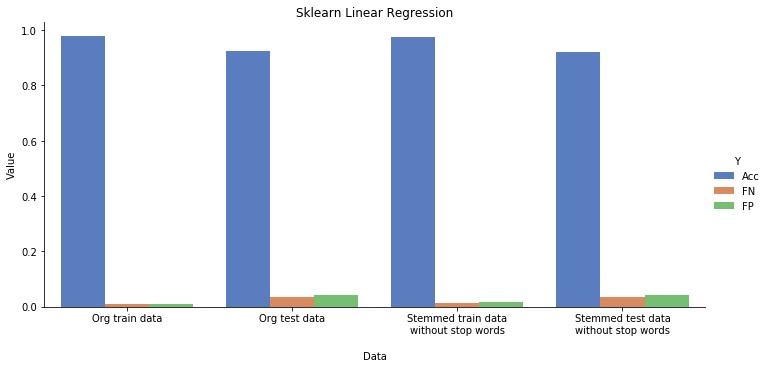

In [141]:
sns.catplot(x="Data", y="Value", hue="Y", data=LG2_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Sklearn Linear Regression")

## Compare our LR with sklearn's

In [142]:
A_df = LGc_res_df[LGc_res_df.Y == 'Acc']
A_df.Y = ['Our'] * 4

B_df = LG2_res_df[LG2_res_df.Y == 'Acc']
B_df.Y = ['Sklearn'] * 4

C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0.5, 1, 'Our Naive Bayes class vs Sklearn MultinomialNaiveBayes')

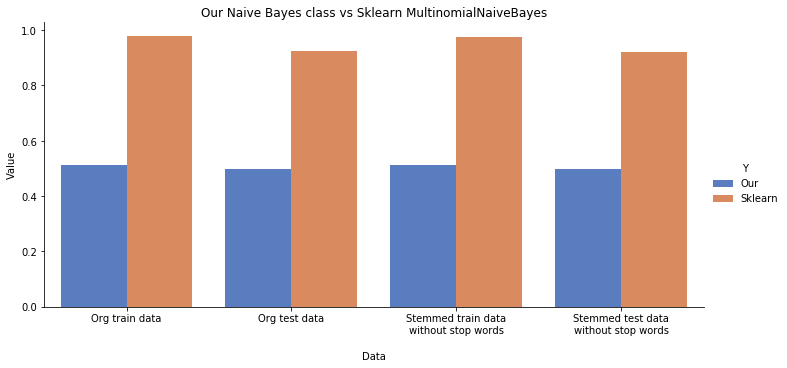

In [143]:
compare_df = pd.concat([A_df,B_df])

sns.catplot(x="Data", y="Value", hue="Y", data=compare_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class vs Sklearn MultinomialNaiveBayes")

# SVM

## SVM class

In [23]:
class SVM:
    def __init__(self,C,gamma,th=1e-5):
        self.C = C
        self.gamma = gamma
        self.th = th
    def fit(self,X,y,info=False):
        m,n = X.shape
        
        # kernel matrix
        if info:
            print(f'Calculating kernel matrix...',end='')
        K = rbf_kernel(X,X,gamma=self.gamma)
        
        # setup solver
        if info:
            print(f'Setting solver...',end='')
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))
        if info:
            print(f'starting solver...')
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        
        # getting support vectors
        self.S = (self.alphas > self.th).reshape(-1, )
        self.support_vextors = X[self.S]
        self.sv_target = y[self.S]
        
        # getting bias
        if info:
            print(f'Calculating bias...',end='')
        K_sv = rbf_kernel(self.support_vextors,self.support_vextors,gamma=self.gamma)
        B = self.sv_target.ravel() - np.sum(K_sv * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1)
        self.bias = sstats.mode(B)[0][0]
        
        if info:
            print(f'done')
        
    def predict(self,X):
        K = rbf_kernel(X,self.support_vextors,gamma=self.gamma)
        preds = np.sign(np.sum(K * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1) + self.bias)
        return preds

## Train and test accuracy

In [80]:
CV = MyCountVectorizer(min_df = 5)

In [81]:
CV.fit(stemmed_swr_train_df)

In [82]:
X_train_SVM,X_test_SVM = CV.transform(stemmed_swr_train_df),CV.transform(stemmed_swr_test_df)

In [87]:
y_train = np.array([-1.0 if r == '1' else 1.0 for r in stemmed_swr_train_df['rating']]).reshape(-1,1)

In [88]:
y_test = np.array([-1.0 if r == '1' else 1.0 for r in stemmed_swr_test_df['rating']]).reshape(-1,1)

In [89]:
C = 1.25
gamma = 0.0025

In [90]:
svm_model = SVM(C,gamma)

In [91]:
svm_model.fit(X_train_SVM,y_train,info=True)

Calculating kernel matrix...Setting solver...starting solver...
     pcost       dcost       gap    pres   dres
 0: -3.0473e+03 -3.7407e+04  2e+05  3e+00  7e-13
 1: -2.1390e+03 -2.5998e+04  4e+04  4e-01  8e-13
 2: -2.0428e+03 -6.1023e+03  4e+03  4e-12  8e-13
 3: -2.6782e+03 -4.2363e+03  2e+03  3e-12  7e-13
 4: -2.8801e+03 -3.8264e+03  9e+02  2e-12  7e-13
 5: -3.0462e+03 -3.4778e+03  4e+02  1e-12  8e-13
 6: -3.1317e+03 -3.3105e+03  2e+02  5e-13  8e-13
 7: -3.1775e+03 -3.2235e+03  5e+01  3e-12  9e-13
 8: -3.1922e+03 -3.1970e+03  5e+00  5e-12  9e-13
 9: -3.1940e+03 -3.1942e+03  2e-01  2e-12  1e-12
10: -3.1941e+03 -3.1941e+03  7e-03  3e-12  9e-13
11: -3.1941e+03 -3.1941e+03  2e-04  1e-12  1e-12
Optimal solution found.
Calculating bias...done


In [94]:
svm_predictions_train = svm_model.predict(X_train_SVM)

In [95]:
M,N,acc = print_score(svm_predictions_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={C}, gamma={gamma}')

Train data, SVM, rbf kernel, C=1.25, gamma=0.0025
Acc: 0.9658258746948739

Confusion matrix:
[[4904  140]
 [ 196 4592]]

True negative (rating = 1): 4904
True positive (rating = 10): 4592
False negative: 140
False positive: 196


In [92]:
svm_predictions = svm_model.predict(X_test_SVM)

In [93]:
M,N,acc = print_score(svm_predictions,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={C}, gamma={gamma}')

Test data, SVM, rbf kernel, C=1.25, gamma=0.0025
Acc: 0.9209659714599341

Confusion matrix:
[[4566  336]
 [ 456 4663]]

True negative (rating = 1): 4566
True positive (rating = 10): 4663
False negative: 336
False positive: 456


## Testing different parameters

In [96]:
SVMc_res_train = []
SVMc_res_test = []

In [97]:
for c in [1.0,1.25,1.5]:
    for gamma_ in [0.001,0.0025,0.005]:
        svm_test_model = SVM(c,gamma_)
        print(f'C: {c}, gamma: {gamma_}')
        svm_test_model.fit(X_train_SVM,y_train,info=False)
        svm_preds_train = svm_test_model.predict(X_train_SVM)
        svm_preds_test = svm_test_model.predict(X_test_SVM)
        M_train,N_train,acc_train = print_score(svm_preds_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        M_test,N_test,acc_test = print_score(svm_preds_test,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_train])
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','FN',M_train[0][1]/N_train])
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','FP',M_train[1][0]/N_train])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_test])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','FN',M_test[0][1]/N_test])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','FP',M_test[1][0]/N_test])
        print()

C: 1.0, gamma: 0.001
     pcost       dcost       gap    pres   dres
 0: -3.5234e+03 -2.9846e+04  2e+05  3e+00  1e-12
 1: -2.4377e+03 -2.2270e+04  3e+04  5e-01  1e-12
 2: -2.3889e+03 -6.1192e+03  4e+03  1e-12  1e-12
 3: -3.0929e+03 -4.2295e+03  1e+03  4e-12  1e-12
 4: -3.3361e+03 -3.8673e+03  5e+02  3e-12  1e-12
 5: -3.4374e+03 -3.7202e+03  3e+02  7e-13  1e-12
 6: -3.5096e+03 -3.6130e+03  1e+02  9e-13  1e-12
 7: -3.5430e+03 -3.5652e+03  2e+01  2e-16  1e-12
 8: -3.5513e+03 -3.5539e+03  3e+00  2e-13  1e-12
 9: -3.5524e+03 -3.5525e+03  1e-01  2e-12  1e-12
10: -3.5524e+03 -3.5524e+03  4e-03  2e-12  1e-12
11: -3.5524e+03 -3.5524e+03  7e-05  4e-12  1e-12
Optimal solution found.
Train data, SVM, rbf kernel, C=1.0, gamma=0.001
Acc: 0.9317534580960131

Confusion matrix:
[[4927  498]
 [ 173 4234]]

True negative (rating = 1): 4927
True positive (rating = 10): 4234
False negative: 498
False positive: 173
Test data, SVM, rbf kernel, C=1.0, gamma=0.001
Acc: 0.9055982436882547

Confusion matrix:
[[4

 5: -3.3317e+03 -3.9077e+03  6e+02  2e-04  9e-13
 6: -3.4138e+03 -3.7421e+03  3e+02  1e-04  9e-13
 7: -3.4853e+03 -3.5982e+03  1e+02  3e-05  9e-13
 8: -3.5164e+03 -3.5388e+03  2e+01  4e-06  1e-12
 9: -3.5238e+03 -3.5254e+03  2e+00  1e-07  1e-12
10: -3.5244e+03 -3.5245e+03  6e-02  4e-09  1e-12
11: -3.5244e+03 -3.5244e+03  1e-03  7e-11  1e-12
Optimal solution found.
Train data, SVM, rbf kernel, C=1.5, gamma=0.0025
Acc: 0.9698942229454841

Confusion matrix:
[[4930  126]
 [ 170 4606]]

True negative (rating = 1): 4930
True positive (rating = 10): 4606
False negative: 126
False positive: 170
Test data, SVM, rbf kernel, C=1.5, gamma=0.0025
Acc: 0.9215647141003892

Confusion matrix:
[[4578  342]
 [ 444 4657]]

True negative (rating = 1): 4578
True positive (rating = 10): 4657
False negative: 342
False positive: 444

C: 1.5, gamma: 0.005
     pcost       dcost       gap    pres   dres
 0: -2.7511e+03 -4.6866e+04  2e+05  2e+00  4e-13
 1: -1.9339e+03 -3.1291e+04  5e+04  3e-01  5e-13
 2: -1.9235e

In [99]:
SVMc_res_train_df = pd.DataFrame(SVMc_res_train,columns = ['Data','Y','Value'])
SVMc_res_test_df = pd.DataFrame(SVMc_res_test,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Stemmed train data without stop words, SVM with rbf kernel')

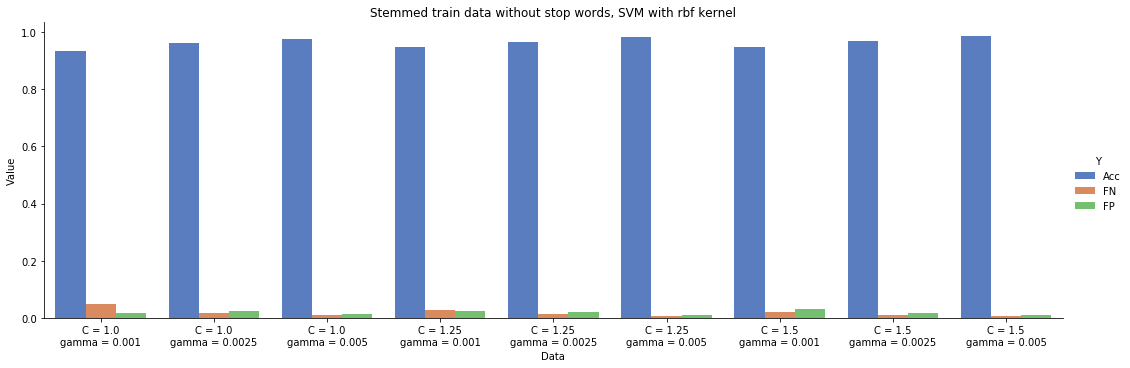

In [103]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMc_res_train_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed train data without stop words, SVM with rbf kernel")

Text(0.5, 1, 'Stemmed test data without stop words, SVM with rbf kernel')

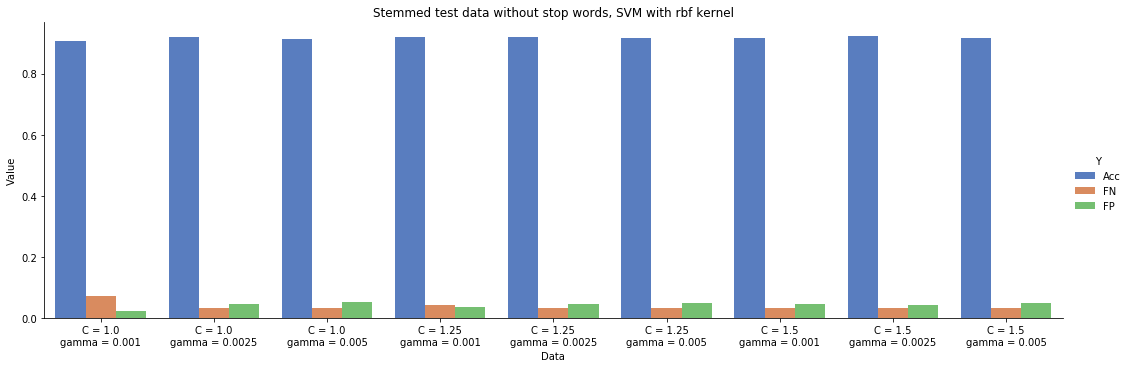

In [104]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMc_res_test_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed test data without stop words, SVM with rbf kernel")

In [105]:
SVMc_res_train_df_copyed = SVMc_res_train_df.copy()
SVM_A_df = SVMc_res_train_df_copyed[SVMc_res_train_df_copyed.Y == 'Acc']
SVM_A_df.Y = ['Train'] * 9
SVMc_res_test_df_copyed = SVMc_res_test_df.copy()
SVM_B_df = SVMc_res_test_df_copyed[SVMc_res_test_df_copyed.Y == 'Acc']
SVM_B_df.Y = ['Test'] * 9
compare_svm_df = pd.concat([SVM_A_df,SVM_B_df])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(0.9, 1.0)

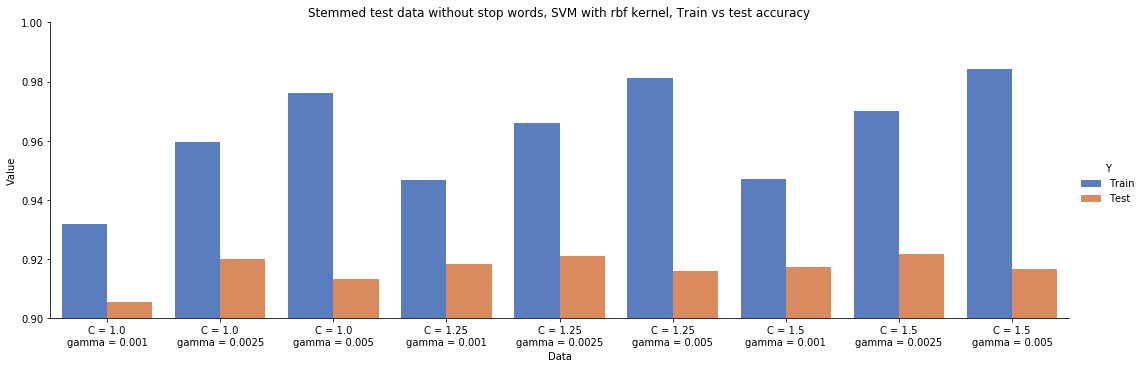

In [109]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed test data without stop words, SVM with rbf kernel, Train vs test accuracy")
plt.ylim(0.9,1.0)

## Sklearn SVM

In [136]:
CV = CountVectorizer(min_df=5)

In [137]:
CV.fit(stemmed_swr_train_df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [138]:
X_train_SVM = CV.transform(stemmed_swr_train_df['text'])
X_test_SVM = CV.transform(stemmed_swr_test_df['text'])

In [142]:
SVMb_res_train = []
SVMb_res_test = []

In [143]:
for c in [1.0,1.25,1.5]:
    for gamma_ in [0.001,0.0025,0.005]:
        svm_test_model = SVC(C=c, kernel='rbf', gamma=gamma_)
        print(f'C: {c}, gamma: {gamma_}')
        svm_test_model.fit(X_train_SVM,y_train.ravel())
        svm_preds_train = svm_test_model.predict(X_train_SVM)
        svm_preds_test = svm_test_model.predict(X_test_SVM)
        M_train,N_train,acc_train = print_score(svm_preds_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        M_test,N_test,acc_test = print_score(svm_preds_test,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_train])
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','FN',M_train[0][1]/N_train])
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','FP',M_train[1][0]/N_train])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_test])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','FN',M_test[0][1]/N_test])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','FP',M_test[1][0]/N_test])
        print()

C: 1.0, gamma: 0.001
Train data, SVM, rbf kernel, C=1.0, gamma=0.001
Acc: 0.9370423108218063

Confusion matrix:
[[4730  249]
 [ 370 4483]]

True negative (rating = 1): 4730
True positive (rating = 10): 4483
False negative: 249
False positive: 370
Test data, SVM, rbf kernel, C=1.0, gamma=0.001
Acc: 0.912882945813791

Confusion matrix:
[[4515  366]
 [ 507 4633]]

True negative (rating = 1): 4515
True positive (rating = 10): 4633
False negative: 366
False positive: 507

C: 1.0, gamma: 0.0025
Train data, SVM, rbf kernel, C=1.0, gamma=0.0025
Acc: 0.9596216436126932

Confusion matrix:
[[4867  164]
 [ 233 4568]]

True negative (rating = 1): 4867
True positive (rating = 10): 4568
False negative: 164
False positive: 233
Test data, SVM, rbf kernel, C=1.0, gamma=0.0025
Acc: 0.9200678574992516

Confusion matrix:
[[4556  335]
 [ 466 4664]]

True negative (rating = 1): 4556
True positive (rating = 10): 4664
False negative: 335
False positive: 466

C: 1.0, gamma: 0.005
Train data, SVM, rbf kernel, C=

In [144]:
SVMb_res_train_df = pd.DataFrame(SVMb_res_train,columns = ['Data','Y','Value'])
SVMb_res_test_df = pd.DataFrame(SVMb_res_test,columns = ['Data','Y','Value'])

Text(0.5, 1, 'Sklearn SVM, Stemmed train data without stop words, SVM with rbf kernel')

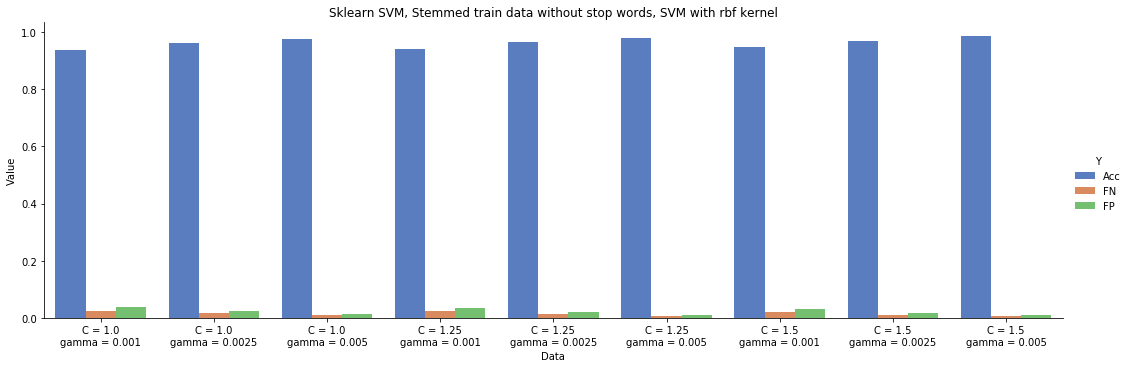

In [145]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMb_res_train_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed train data without stop words, SVM with rbf kernel")

Text(0.5, 1, 'Sklearn SVM, Stemmed test data without stop words, SVM with rbf kernel')

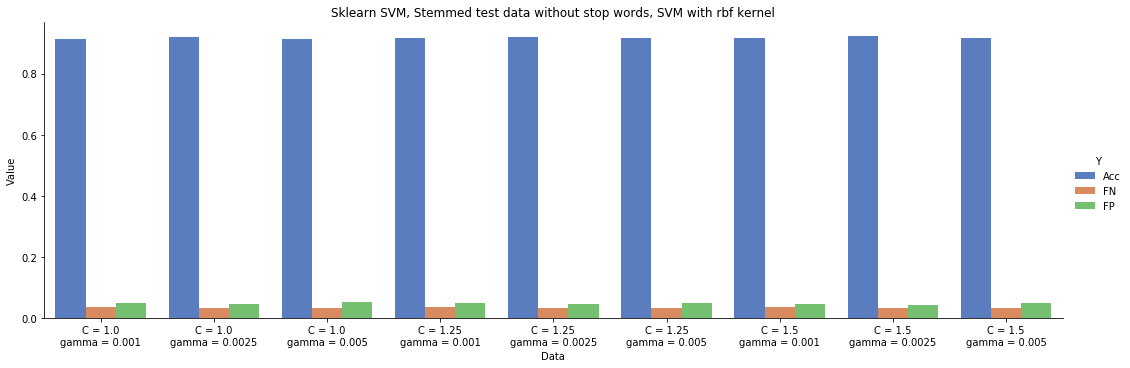

In [146]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMb_res_test_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed test data without stop words, SVM with rbf kernel")

In [147]:
SVMb_res_train_df_copyed = SVMb_res_train_df.copy()
SVMb_A_df = SVMb_res_train_df_copyed[SVMb_res_train_df_copyed.Y == 'Acc']
SVMb_A_df.Y = ['Train'] * 9
SVMb_res_test_df_copyed = SVMb_res_test_df.copy()
SVMb_B_df = SVMb_res_test_df_copyed[SVMb_res_test_df_copyed.Y == 'Acc']
SVMb_B_df.Y = ['Test'] * 9
compare_svmb_df = pd.concat([SVMb_A_df,SVMb_B_df])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(0.9, 1.0)

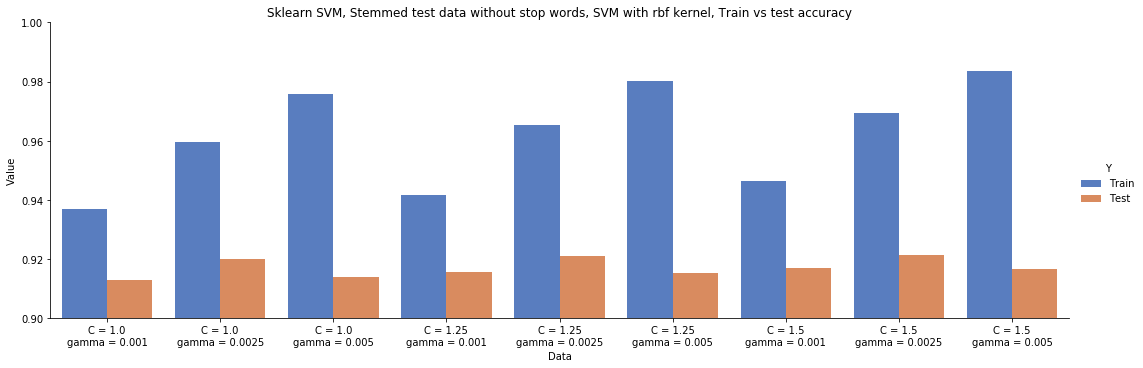

In [148]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svmb_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed test data without stop words, SVM with rbf kernel, Train vs test accuracy")
plt.ylim(0.9,1.0)

## Compare our SVM with sklearn`s

In [149]:
SVMc1_res_train_df_copyed = SVMc_res_train_df.copy()
SVMc1_A_df = SVMc1_res_train_df_copyed[SVMc1_res_train_df_copyed.Y == 'Acc']
SVMc1_A_df.Y = ['Our'] * 9
SVMb1_res_train_df_copyed = SVMb_res_train_df.copy()
SVMb1_B_df = SVMb1_res_train_df_copyed[SVMb1_res_train_df_copyed.Y == 'Acc']
SVMb1_B_df.Y = ['Sklearn'] * 9
compare_svm1_df = pd.concat([SVMc1_A_df,SVMb1_B_df])

Text(0.5, 1, 'Our SVM class vs Sklearn SVC SVM, Stemmed train data without stop words')

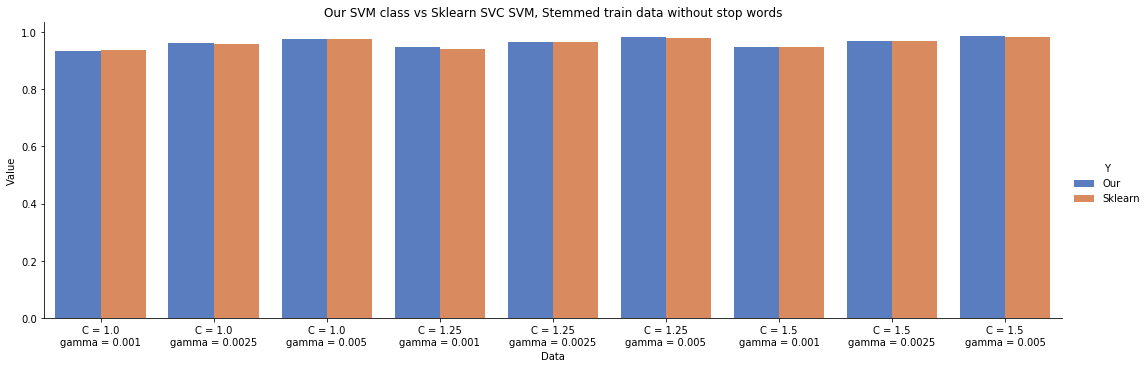

In [150]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm1_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Our SVM class vs Sklearn SVC SVM, Stemmed train data without stop words")

In [151]:
SVMc2_res_test_df_copyed = SVMc_res_test_df.copy()
SVMc2_A_df = SVMc2_res_test_df_copyed[SVMc2_res_test_df_copyed.Y == 'Acc']
SVMc2_A_df.Y = ['Our'] * 9
SVMb2_res_test_df_copyed = SVMb_res_test_df.copy()
SVMb2_B_df = SVMb2_res_test_df_copyed[SVMb2_res_test_df_copyed.Y == 'Acc']
SVMb2_B_df.Y = ['Sklearn'] * 9
compare_svm2_df = pd.concat([SVMc2_A_df,SVMb2_B_df])

Text(0.5, 1, 'Our SVM class vs Sklearn SVC SVM, Stemmed test data without stop words')

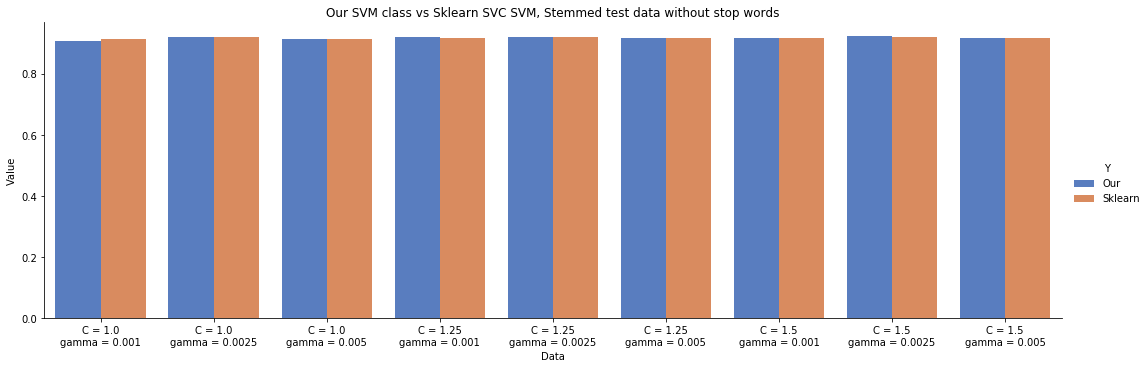

In [152]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm2_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Our SVM class vs Sklearn SVC SVM, Stemmed test data without stop words")